In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
plt.ion()   # interactive mode

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
data_dir = os.path.join('drive','My Drive','Colab Notebooks','DL_CNN','image') 

In [ ]:
data_transform = transforms.Compose([transforms.RandomRotation(90),
                                     transforms.Resize([256,256]),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), transform = data_transform) for x in ['train','test']}
data_loaders = {x: DataLoader(image_datasets[x],
                              batch_size = 16, 
                              shuffle = True, 
                              num_workers = 16) for x in ['train','test']}
#data_loaders  ## right now data_loaders is a list contains two dataloader

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}
dataset_sizes

{'test': 1296, 'train': 5885}

In [ ]:
train_dataset = image_datasets['train']
train_dataset.class_to_idx

{'AnneHathaway': 0,
 'DavidBowie': 1,
 'EmiliaClarke': 2,
 'EmmaStone': 3,
 'GalGadot': 4,
 'HughJachman': 5,
 'JasonStatham': 6,
 'JohnnyDepp': 7,
 'LeonardoDicaprio': 8,
 'MorganFreeman': 9,
 'Robert': 10,
 'RogerFederer': 11,
 'ScarlletJohansson': 12,
 'TomCruise': 13,
 'WillSmith': 14}

In [ ]:
num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(data_loaders['train']):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        

        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 16
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 16
break minibatch for-loop


# Train function

In [ ]:
def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    

  
    
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
 

In [ ]:
def train(model, train_loader, test_loader, NUM_EPOCHS):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost
    


## Model

In [ ]:
### some settings
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda:0"
num_classes = len(image_datasets['train'].classes)

In [ ]:
res101 = models.resnet101(pretrained = True)
for parameter in res101.parameters():
    parameter.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:01, 97755852.76it/s] 


In [ ]:
res101.fc = nn.Sequential(
           nn.Linear(in_features=2048, out_features=1000, bias=True),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=1000, out_features= num_classes, bias=True))

In [ ]:
train_loader = data_loaders['train']
test_loader = data_loaders['test']

In [ ]:
res101 = res101.to(DEVICE)
#res50 = res50.to(DEVICE)
#res101 = res101.to(DEVICE)
#res152 = res152.to(DEVICE)
optimizer = torch.optim.Adam(res101.parameters())

In [ ]:
minibatch_cost, epoch_cost = train(res101, train_loader, test_loader, NUM_EPOCHS = 30)

Epoch: 001/030 | Batch 0000/0368 | Cost: 2.7683
Epoch: 001/030 | Batch 0150/0368 | Cost: 2.0997
Epoch: 001/030 | Batch 0300/0368 | Cost: 2.1976
Epoch: 001/030 | Train: 27.171%
Time elapsed: 8.73 min
Epoch: 002/030 | Batch 0000/0368 | Cost: 2.1437
Epoch: 002/030 | Batch 0150/0368 | Cost: 1.9946
Epoch: 002/030 | Batch 0300/0368 | Cost: 2.0143
Epoch: 002/030 | Train: 31.725%
Time elapsed: 16.77 min
Epoch: 003/030 | Batch 0000/0368 | Cost: 2.2869
Epoch: 003/030 | Batch 0150/0368 | Cost: 2.0698
Epoch: 003/030 | Batch 0300/0368 | Cost: 2.0369
Epoch: 003/030 | Train: 34.002%
Time elapsed: 24.85 min
Epoch: 004/030 | Batch 0000/0368 | Cost: 2.1945
Epoch: 004/030 | Batch 0150/0368 | Cost: 2.3887
Epoch: 004/030 | Batch 0300/0368 | Cost: 1.3769
Epoch: 004/030 | Train: 38.301%
Time elapsed: 32.87 min
Epoch: 005/030 | Batch 0000/0368 | Cost: 1.7791
Epoch: 005/030 | Batch 0150/0368 | Cost: 1.7860
Epoch: 005/030 | Batch 0300/0368 | Cost: 2.1166
Epoch: 005/030 | Train: 35.259%
Time elapsed: 40.92 min
E

Test accuracy: 35.88%


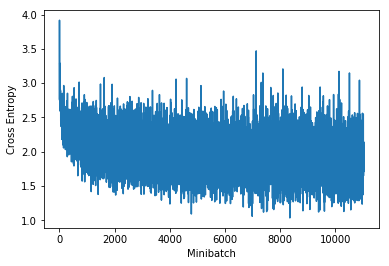

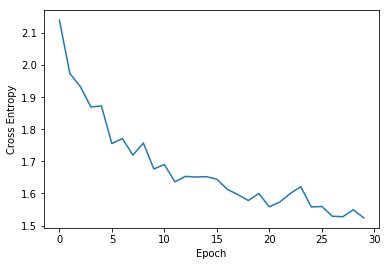

In [ ]:
test_loader = data_loaders['test']
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(res101, test_loader)))
    



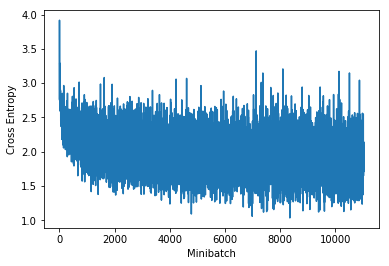

In [ ]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.savefig(os.path.join('drive','My Drive','Colab Notebooks','DL_CNN','Minibatch.jpg'))#,dpi = 400)
plt.show()


In [ ]:
dire = os.path.join('drive','My Drive','Colab Notebooks','DL_CNN')
dire

'drive/My Drive/Colab Notebooks/DL_CNN'

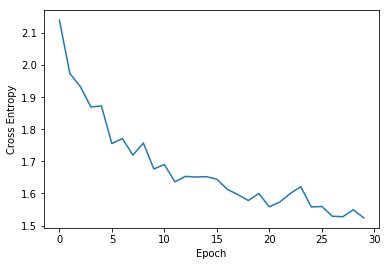

In [ ]:

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.savefig(os.path.join('drive','My Drive','Colab Notebooks','DL_CNN','epoch.jpg'))#,dpi = 400)
plt.show()

In [ ]:
with open(os.path.join(dire,'minibatch_cost.txt'), 'w') as f:
    for item in minibatch_cost:
        f.write("%s\n" % item)

In [ ]:
with open(os.path.join(dire,'epoch_cost.txt'), 'w') as f:
    for item in epoch_cost:
        f.write("%s\n" % item)

In [ ]:
with open(os.path.join(dire,'epoch_cost.txt'), 'r') as f:
    my_list = [line.rstrip('\n') for line in f]

In [ ]:
my_list

["tensor(2.1397, device='cuda:0')",
 "tensor(1.9734, device='cuda:0')",
 "tensor(1.9326, device='cuda:0')",
 "tensor(1.8695, device='cuda:0')",
 "tensor(1.8728, device='cuda:0')",
 "tensor(1.7555, device='cuda:0')",
 "tensor(1.7713, device='cuda:0')",
 "tensor(1.7195, device='cuda:0')",
 "tensor(1.7572, device='cuda:0')",
 "tensor(1.6764, device='cuda:0')",
 "tensor(1.6902, device='cuda:0')",
 "tensor(1.6363, device='cuda:0')",
 "tensor(1.6534, device='cuda:0')",
 "tensor(1.6512, device='cuda:0')",
 "tensor(1.6526, device='cuda:0')",
 "tensor(1.6444, device='cuda:0')",
 "tensor(1.6129, device='cuda:0')",
 "tensor(1.5965, device='cuda:0')",
 "tensor(1.5782, device='cuda:0')",
 "tensor(1.6000, device='cuda:0')",
 "tensor(1.5584, device='cuda:0')",
 "tensor(1.5736, device='cuda:0')",
 "tensor(1.6001, device='cuda:0')",
 "tensor(1.6210, device='cuda:0')",
 "tensor(1.5582, device='cuda:0')",
 "tensor(1.5597, device='cuda:0')",
 "tensor(1.5292, device='cuda:0')",
 "tensor(1.5277, device='cud

In [ ]:
epoch_cost

[tensor(2.1397, device='cuda:0'),
 tensor(1.9734, device='cuda:0'),
 tensor(1.9326, device='cuda:0'),
 tensor(1.8695, device='cuda:0'),
 tensor(1.8728, device='cuda:0'),
 tensor(1.7555, device='cuda:0'),
 tensor(1.7713, device='cuda:0'),
 tensor(1.7195, device='cuda:0'),
 tensor(1.7572, device='cuda:0'),
 tensor(1.6764, device='cuda:0'),
 tensor(1.6902, device='cuda:0'),
 tensor(1.6363, device='cuda:0'),
 tensor(1.6534, device='cuda:0'),
 tensor(1.6512, device='cuda:0'),
 tensor(1.6526, device='cuda:0'),
 tensor(1.6444, device='cuda:0'),
 tensor(1.6129, device='cuda:0'),
 tensor(1.5965, device='cuda:0'),
 tensor(1.5782, device='cuda:0'),
 tensor(1.6000, device='cuda:0'),
 tensor(1.5584, device='cuda:0'),
 tensor(1.5736, device='cuda:0'),
 tensor(1.6001, device='cuda:0'),
 tensor(1.6210, device='cuda:0'),
 tensor(1.5582, device='cuda:0'),
 tensor(1.5597, device='cuda:0'),
 tensor(1.5292, device='cuda:0'),
 tensor(1.5277, device='cuda:0'),
 tensor(1.5492, device='cuda:0'),
 tensor(1.5239